<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=137906129" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import spx_strategies as ss
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
# Delta values must be scaled from 0.0 to 1.0 (0 delta to 100 delta)
delta_sp = 0.214
delta_lp = 0.001
delta_sc = 0.201
delta_lc = 0.001
delta_params = {'delta_sp':delta_sp, 'delta_lp':delta_lp, 'delta_sc':delta_sc,'delta_lc':delta_lc}

same_day = False
purchase_time = '15:45:00'

# Max loss is % : max_loss * amount_collected is exit criteria
max_loss = 100

# In dollars
commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0


files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
    #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
 #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
  #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
  # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
   f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    df['dte'] = ((df['expiration'] - df['quote_date']) / np.timedelta64(1, 'D')).astype('int')

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-short-straddle-study_2021-2022_1DTE_1.db
Copying db file to output : optimal-iron-condor-study_2022_1.db
Copying db file to output : optimal-iron-condor-study.db


# New strategy schema focused on static and dynamic entry and exit policies

This code will be moved to a plugin notebook after it is stable

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from abc import ABC, abstractmethod

#########
# Abstract Strategy & Abstract Policy
#########

class AbstractStrategy(ABC):
    def __init__(self, entry_policy, exit_policy, df_ty, initial_portfolio_value, commission = 1.5, debug = False):
        self.entry_policy = entry_policy
        self.exit_policy = exit_policy
        self.commission = commission
        self.initial_portfolio_value = initial_portfolio_value
        self.df_ty = df_ty
        self.debug = debug
        self.df_trades = None
       
    def performCalcs(self):
        df_trades = self.df_trades
        df_trades['commission'] = df_trades['trade_count']*commission
        df_trades['lost'] = df_trades['lost_c'] + df_trades['lost_p']
        df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
        df_trades['portfolio_value'] = 0.0
        #df_trades['daily_return'] = 0.0
        #df_trades['margin_utilization']=0.0
        initial_portfolio_value = self.initial_portfolio_value
        df_trades['net_cumsum']=df_trades['net'].cumsum()

        df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
        df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
        net = df_trades['net'].iloc[0]
        df_trades.loc[0,'transaction_return'] = df_trades['net'].iloc[0] / initial_portfolio_value
        df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

        df_ty = self.df_ty.copy()
        df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
        df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

        df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
        df_trades.drop(['Date'],axis=1,inplace=True)

        # if you want to scale the chart, you should do it here
        factor = 1.0
        df_trade_plot = df_trades.copy()
        df_trade_plot['net'] = df_trade_plot['net']*factor
        df_trade_plot.set_index('expiration', inplace=True)
        df_trade_plot = df_trade_plot['net'].cumsum()
        
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        secax = ax.secondary_yaxis('right', functions=(self.net2pct, self.pct2net))
        secax.set_ylabel('% return')
        df_trade_plot.plot(ax=ax)
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"{str(self)}.png")
        if self.debug == False:
            plt.close(fig)

        df_trades_transaction_return = df_trades.copy()
        df_trades_transaction_return['transaction_return'] *= 100 
        df_trades_transaction_return.set_index('expiration', inplace=True)
        fig = plt.figure()
        ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
        ax.set_ylabel('Transaction Return %')
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"daily_ret_{str(self)}.png")
        if self.debug == False:
            plt.close(fig)
        

        trade_count = df_trades.shape[0]
        win_count = df_trades[df_trades['net']>0].shape[0]
        loss_count = df_trades[df_trades['net']<0].shape[0]
        std_trans_return = df_trades['transaction_return'].std()
        std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
        self.df_trades = df_trades
        if self.debug:
            print("*****  BACKTEST RESULTS  ****")
            print(
                f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
                f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
                f"\n{'Trading Days:':<35}{trade_count:>10}",
                f"\n{'Wins:':<35}{win_count:>10}",
                f"\n{'Losses:':<35}{loss_count:>10}",
                f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
                f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
                f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
                f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
                f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
                f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
                f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
                f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
                f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
                f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
                f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",
                f"\n{'Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3):>10}",
                f"\n{'Dampened Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/np.sqrt(std_trans_return),3):>10}",
                f"\n"
            )
            
        # The reason this number outputs like this, is because we were running a optimizer,
        # and we wanted a single "fitness" value that the optimizer could optimize
        # TODO : if Debug = True, output a dictionary with all of the values above
        risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3)
        damp_risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/np.sqrt(std_trans_return),3)
        return risk_adj_cum_return
        
    def net2pct(self,x):
        return (x / initial_portfolio_value)*100

    def pct2net(self,x):
        return initial_portfolio_value * x/100
        
    @abstractmethod
    def evaluate(self,df):
        pass
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractPolicy(ABC):
    def getRoundedSlippedPrice(self,bid,ask, trans_type):
        mid = (bid + ask)/0.02
        if mid % 1 != 0.0:
            # We need to slip the bid/ask spread
            if trans_type == 'sell':
                ask -= 0.05
            elif trans_type=='buy':
                bid += 0.05

        mid = round((bid + ask)/0.02,1)
        return mid
    
    def len_check(self,df, opt_type, strike, contract_date, quote_time):
        if len(df)==0:
            raise Exception(f"Fatal error. Option Type {opt_type} | Strike : {strike} not found for date : {contract_date} and time : {quote_time}")
    
    def get_contract_strike(self, curr_date, contract_date, target_delta, i_df, trans_type):
        # -1 means no delta should be selected
        if target_delta ==-1:
            return pd.Series([0,0,0])
#         df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
        df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)]
    
        if len(df1) == 0:
            print(f"WARNING : get_contract_strike no records found: {curr_date}, {contract_date}")
            return pd.Series([0,0,0])
        
        df1 = df1.iloc[0]
        rounded_price = self.getRoundedSlippedPrice(df1['ask'],df1['bid'],trans_type)

        
        return pd.Series([df1['strike'],df1['delta'],rounded_price])
    
    def get_amount_lost(self,df,row):
        contract_date = row['expiration']
        
        df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')]
        underlying = df1['price']

        if len(underlying)==0:
            raise Exception(f"Fatal error. Underlying price not found for date : {contract_date} and time : '16:00:00'")

        underlying = underlying.iloc[0]
        
        total_lost_c = 0.0
        total_lost_p = 0.0
        for col in row.index.values:
            if 'strike_sc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c + (underlying - row[col])*100
            if 'strike_lc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c - (underlying - row[col])*100
            if 'strike_sp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p + (row[col] - underlying)*100
            if 'strike_lp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p - (row[col] - underlying)*100
        return pd.Series([total_lost_c, total_lost_p])

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass

In [3]:
#########
# AbstractEntry, AbstractDynamicEntryPolicy, AbstractStaticEntryPolicy
#########

class AbstractEntryPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass

class AbstractDynamicEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission):
        super().__init__(commission)
    
    @abstractmethod
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
class AbstractStaticEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission, dte, trade_time):
        self.dte = dte
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass

In [4]:
#####
# Dynamic Entry Policies
#####

class AlwaysOpenShortStraddleDynamicEntryPolicy(AbstractDynamicEntryPolicy):
    def __init__(self, commission, dte, delta_sp, delta_sc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.dte = dte
        self.summary = f"Dynamic Entry Short Straddle. SP Delta : {delta_sp} SC Delta : {delta_sc}"
        super().__init__(commission)
    
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        df_trades = None
        if (df_trade_row is None or (df_trade_row['expiration'] == eval_date and eval_time=='16:00:00') or df_trade_row['expiration'] < eval_date or df_trade_row['lost_p']>0 or df_trade_row['lost_c']>0):
            #populate a new trade
            strike_sc, delta_sc, collected_sc, strike_sp, delta_sp, collected_sp, trade_count = 0,0,0,0,0,0,0
            expiration_p, expiration_c = None, None

            # create call/put dataframe slice if needed
            df_purchase_time = df_data[(df_data['dte']==self.dte) & (df_data['quote_time'] == eval_time)]
            df_c = df_purchase_time[(df_purchase_time['type']=="C")]
            df_p = df_purchase_time[(df_purchase_time['type']=="P")]
            
            if df_c.shape[0] == 0:
                if False:
                    print(f"***WARNING*** : No calls were found with static rules: {eval_date} | {eval_time}")
            else:
                ##### SHORT CALL #####
                expiration_c = df_c['expiration'].min()
                df_sc = df_c[(df_c['delta']<= self.delta_sc)]
                df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
                # print(f"get_contract_strike : {eval_date}, {expiration_c}, {self.delta_sc}, {df_sc.shape[0]}")
                strike_sc, delta_sc, collected_sc = self.get_contract_strike(eval_date, expiration_c,self.delta_sc, df_sc,'sell')

                
            if df_p.shape[0] == 0:
                if False:
                    print(f"***WARNING*** : No puts were found with static rules: quote date : {eval_date}")
            else:
                #### SHORT PUT ####
                expiration_p = df_p['expiration'].min()
                df_sp = df_p[(df_p['delta']<= self.delta_sp)]
                df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
                strike_sp, delta_sp, collected_sp = self.get_contract_strike(eval_date, expiration_p,self.delta_sp, df_sp,'sell')


            if strike_sc > 0.0:
                trade_count += 1
            if strike_sp > 0.0:
                trade_count += 1
                
            if trade_count == 0:
                return None

            if expiration_p is not None and expiration_c is not None and expiration_p != expiration_c:
                print("ERROR : put and call expirations are different within single straddle transaction. Trade nullified")
                return None
            else:
                expiration = expiration_p or expiration_c
            
            df_trades = pd.DataFrame([{'trade_date':eval_date, 'expiration':expiration, 'trade_count':trade_count, 
                               'delta_sc_target' : self.delta_sc,'delta_sp_target': self.delta_sp, 'strike_sc': strike_sc, 
                               'delta_sc':delta_sc, 'collected_sc': collected_sc, 'strike_sp': strike_sp,'delta_sp': delta_sp, 
                               'collected_sp': collected_sp, 'collected': collected_sc + collected_sp, 'lost_c': 0, 'lost_p' : 0}])
        
        return df_trades
    
    def __str__(self):
        self.summary

    def __repr__(self):
        self.summary

In [5]:
#### Basic Strategy Types

class StaticEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv, timestep, debug = False):
            entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
            exit_policy = AbstractDynamicExitPolicy(commission, timestep)
            self.summary = f"{str(entry_policy)} {str(exit_policy)}"
            super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        
        
        self.df_trades['lost_c'] = 0.0
        self.df_trades['lost_p'] = 0.0
        
        df_times = pd.DataFrame(df['quote_time'].unique())
        df_times[0] = pd.to_datetime(df_times[0], format='%H:%M:%S').dt.time
        df_times.rename(columns={0: "quote_time"},inplace=True)
        df_times = df_times.sort_values(by='quote_time')
        
        start_time_timer = perf_counter()
        for index, trow in df_times.iterrows():           
            min_i = int(trow[0].strftime("%M"))
            curr_time = trow[0]
            start_time = time(hour=9, minute=30)
            end_time = time(hour=16)
            if (end_time < curr_time or curr_time <= start_time):
                continue
            str_quote_time = trow[0].strftime("%H:%M:%S")
            df_qt = df[(df['quote_time']==str_quote_time)]

            # print(f"Num rows at {str_quote_time} : {df_qt.shape[0]}")

            self.df_trades['trade_count'],self.df_trades['lost_c'], self.df_trades['lost_p'] = self.df_trades.apply(
                lambda row : self.exit_policy.evaluateTradingCondition(None, str_quote_time, row, df_qt), axis=1).T.values
            stop_time_timer = perf_counter()
            # print(df_trades.head())

            if min_i % 30 == 0:
                print(f"Processed {curr_time} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class DynamicEntryDynamicExitStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv, debug = False):
            entry_policy = AbstractDynamicEntryPolicy(commission)
            exit_policy = AbstractDynamicExitPolicy(commission, None)
            self.summary = f"{str(entry_policy)} {str(exit_policy)}"
            self.df_trades = pd.DataFrame(columns=['trade_date', 'expiration', 'trade_count', 
                                                   'delta_sc_target','delta_sp_target', 'strike_sc', 
                                                   'delta_sc', 'collected_sc', 'strike_sp','delta_sp', 
                                                   'collected_sp', 'collected', 'lost_c', 'lost_p'])
            super().__init__(entry_policy, exit_policy, df_ty, ipv, commission, debug)

    def evaluate(self,df):
        df.loc[:,'quote_datetime'] = pd.to_datetime(df['quote_date'].astype(str)+' '+df['quote_time'].astype(str))
        df_datetimes = pd.DataFrame(df['quote_datetime'].unique())
        df_datetimes.rename(columns={0: "quote_datetime"},inplace=True)
        df_datetimes = df_datetimes.sort_values(by='quote_datetime')

        start_time_timer = perf_counter()
        df_dt = None
        for index, trow in df_datetimes.iterrows():
            day_i = int(trow[0].strftime("%d"))
            hour_i = int(trow[0].strftime("%H"))

            start_time = time(hour=9, minute=30)
            end_time = time(hour=16)
            curr_time = trow[0].time()
            str_quote_time = curr_time.strftime("%H:%M:%S")
            curr_date = pd.to_datetime(trow[0]).floor('D')

            if (end_time < curr_time or curr_time < start_time):
                continue

            # To save computation, pre-filter each time the date changes
            if df_dt is None or df_dt['quote_date'].iloc[0] != curr_date:
                df_dt = df[df['quote_date']==curr_date]
                #print(f"Iteration date : {curr_date} and time {str_quote_time}. DF rows {df.shape[0]}. df_dt rows : {df_dt.shape[0]}")

            # Design decision : we'll just try to enter and exit once each minute. This means that if we exit a position,
            # about 1 minute will pass before we decide to re-enter
            # 
            # To keep evalute trading decision method signature the same, we'll pass in a row: the last row of df_trades.
            # This leaves the possibility of having no rows.
            # Thus, every dynamic policy must account for getting no row.
            last_trade = None
            if self.df_trades.shape[0] > 0:
                last_trade = self.df_trades.iloc[-1]
            new_trade = self.entry_policy.evaluateTradingCondition(curr_date, str_quote_time, last_trade, df_dt)
            if new_trade is not None:
                self.df_trades = pd.concat([self.df_trades, new_trade], ignore_index=True)

            if self.df_trades.shape[0] > 0:
                last_trade = self.df_trades.iloc[-1]
            if last_trade is not None:
                if last_trade['expiration'] >= curr_date:
                    #print(f"call : evaluateTradingCondition {curr_date}, {str_quote_time}, {last_trade['expiration']}, {df_dt.shape[0]}")
                    trade_count, lost_c, lost_p = self.exit_policy.evaluateTradingCondition(curr_date, str_quote_time, last_trade, df_dt)
#                     if lost_c > 0 or lost_p > 0:
#                         print("Trying to propagate a loss into the future.")
                    self.df_trades.loc[self.df_trades.index[-1],'trade_count'] = trade_count
                    self.df_trades.loc[self.df_trades.index[-1],'lost_c'] = lost_c
                    self.df_trades.loc[self.df_trades.index[-1],'lost_p'] = lost_p

            
            
            stop_time_timer = perf_counter()

            if day_i == 28 and hour_i == 16:
                print(f"Processed {trow.iloc[0]} | Elapsed : {stop_time_timer - start_time_timer}")
                start_time_timer = stop_time_timer
        
        return self.performCalcs()


    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticEntryHoldToExpStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv):
        entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
        exit_policy = AbstractStaticExitPolicy(commission, trade_time)
        self.summary = f"{str(entry_policy)} {str(exit_policy)}"
        super().__init__(entry_policy, exit_policy, df_ty, ipv, commission)
        
    def evaluate(df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

In [6]:
class AlwaysOpenShortStraddleDynamicEntryDynamicMaxLossExitStrategy(DynamicEntryDynamicExitStrategy):
    def __init__(self, commission, dte, delta_sp, delta_sc, df_ty, ipv, max_loss, debug = False):
            self.entry_policy = AlwaysOpenShortStraddleDynamicEntryPolicy(commission, dte, delta_sp, delta_sc)
            self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
            self.df_ty = df_ty
            self.initial_portfolio_value = ipv
            self.commission = commission
            self.debug = debug
            self.summary = f"Always open short straddle after max loss {max_loss}. SP : {delta_sp} SC : {delta_sc}"
            self.df_trades = pd.DataFrame(columns=['trade_date', 'expiration', 'trade_count', 
                                                   'delta_sc_target','delta_sp_target', 'strike_sc', 
                                                   'delta_sc', 'collected_sc', 'strike_sp','delta_sp', 
                                                   'collected_sp', 'collected', 'lost_c', 'lost_p'])

    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

In [7]:
    
    
class AbstractExitPolicy(AbstractPolicy):
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractDynamicExitPolicy(AbstractExitPolicy):
    def __init__(self, commission, timestep):
        self.timestep = timestep
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    @abstractmethod
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    

    
class AbstractStaticExitPolicy(AbstractExitPolicy):
    def __init__(self,commission, trade_time):
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
    
class ShortStraddleStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp=None, delta_sc=None, yield_sp=None, yield_sc=None, ipv = None):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.yield_sp = yield_sp
        self.yield_sc = yield_sc
        self.ipv = ipv
        if delta_sp is not None and delta_sc is not None:
            self.summary = f"Short Straddle. SP Delta : {delta_sp} SC Delta : {delta_sc}"
        elif yield_sp is not None and yield_sc is not None and ipv is not None:
            self.summary = f"Short Straddle. SP Yield : {yield_sp:.3%} SC Yield : {yield_sc:.3%}"
        else:
            raise Exception("Invalid configuration. Configure delta or yield for both SP / SC")
        
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        if self.delta_sp is not None and self.delta_sc is not None:
            return self.populateTradesForDelta(df, df_trades)
        
        if self.yield_sp is not None and self.yield_sc is not None:
            return self.populateTradesForYield(df, df_trades)
    
    def populateTradesForDelta(self,df,df_trades):
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")

        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No puts were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc,'sell'), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp,'sell'), axis = 1).T.values
        
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp']
        
        return df_trades
    
    def populateTradesForYield(self,df,df_trades):
        df_trades['yield_sc_target'] = self.yield_sc
        sc_target = self.ipv*self.yield_sc / 100
        df_trades['yield_sp_target'] = self.yield_sp
        sp_target = self.ipv*self.yield_sp / 100
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
            
        df['yield_sc_target'] = self.yield_sc 
        df['yield_sp_target'] = self.yield_sp 
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No puts were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['ask']> sc_target)]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])['strike'].idxmax()]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],None, df_sc,'sell'), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['ask']> sp_target)]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])['strike'].idxmin()]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],None, df_sp,'sell'), axis = 1).T.values
        
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp']
        
        return df_trades
    
class ShortIronCondorStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp=None, delta_sc=None, 
                 delta_lp=None, delta_lc=None, yield_sp=None, yield_sc=None, yield_lp=None,
                 yield_lc=None, ipv=None):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.delta_lp = delta_lp
        self.delta_lc = delta_lc
        self.yield_sp = yield_sp
        self.yield_sc = yield_sc
        self.yield_lp = yield_lp
        self.yield_lc = yield_lc
        self.ipv = ipv
        if delta_sp is not None and delta_sc is not None and delta_lp is not None and delta_lc is not None:
            self.summary = f"Short IronCondor. Deltas : SP: {delta_sp:.3f} LP: {delta_lp:.3f} SC: {delta_sc:.3f} LC: {delta_lc:.3f}"
        elif yield_sp is not None and yield_sc is not None and yield_lp is not None and yield_lc is not None and ipv is not None :
            self.summary = f"Short IronCondor. SP Yield : {yield_sp:.3%} SC Yield : {yield_sc:.3%}"
        else:
            raise Exception("Invalid configuration. Configure delta or yield and ipv")        
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary


    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        if delta_sp is not None and delta_sc is not None and delta_lp is not None and delta_lc is not None:
            return populateTradesForDelta(self,df,df_trades)
        elif yield_sp is not None and yield_sc is not None and yield_lp is not None and yield_lc is not None and ipv is not None :
            populateTradesForYield(self,df,df_trades)
        
        def populateTradesForDelta(self,df,df_trades):
            df_trades['delta_sc_target'] = self.delta_sc
            df_trades['delta_sp_target'] = self.delta_sp
            df_trades['delta_lc_target'] = self.delta_lc
            df_trades['delta_lp_target'] = self.delta_lp

            #TODO : Throw exception if no trades are found
            if df_trades.shape[0] == 0:
                print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")

            df['delta_sc_target'] = self.delta_sc
            df['delta_sp_target'] = self.delta_sp
            df['delta_lc_target'] = self.delta_lc
            df['delta_lp_target'] = self.delta_lp

            # create call/put dataframe slice if needed
            df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
            df_c = df_purchase_time[(df_purchase_time['type']=="C")]
            df_p = df_purchase_time[(df_purchase_time['type']=="P")]

            if df_c.shape[0] == 0:
                print("***WARNING*** : No calls were found with static rules.")

            if df_p.shape[0] == 0:
                print("***WARNING*** : No calls were found with static rules.")

            ##### SHORT CALL #####
            df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
            df_sc = df_sc.loc[df_sc.groupby(['quote_date'])['delta'].idxmax()]
            df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
                lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc, 'sell'), axis = 1).T.values

            #### SHORT PUT ####
            df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
            df_sp = df_sp.loc[df_sp.groupby(['quote_date'])['delta'].idxmax()]
            df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
                lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp, 'sell'), axis = 1).T.values

            ###### LONG CALL #####
            df_lc = df_c[(df_c['delta']>= df_c['delta_lc_target'])]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
            df_lc = df_lc.loc[df_lc.groupby(['quote_date'])['delta'].idxmin()]
            df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(
                lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lc_target'], df_lc, 'buy'), axis = 1).T.values
            df_trades['collected_lc'] = df_trades['collected_lc']*-1

            ###### LONG PUT #####
            df_lp = df_p[(df_p['delta']>= df_p['delta_lp_target'])]
            df_lp = df_lp.loc[df_lp.groupby(['quote_date'])['delta'].idxmin()]
            df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(
                lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lp_target'], df_lp, 'buy'), axis = 1).T.values
            df_trades['collected_lp']=df_trades['collected_lp']*-1

            #TODO - clean this up. 
            for index, row in df_trades.iterrows():
                if df_trades.loc[index,'strike_sc'] > 0.0:
                    df_trades.loc[index,'trade_count']+=1
                if df_trades.loc[index,'strike_sp'] > 0.0:
                    df_trades.loc[index,'trade_count']+=1
                if df_trades.loc[index,'strike_lc'] > 0.0:
                    df_trades.loc[index,'trade_count']+=1
                if df_trades.loc[index,'strike_lp'] > 0.0:
                    df_trades.loc[index,'trade_count']+=1

            df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] + df_trades['collected_lc'] + df_trades['collected_lp']

            return df_trades
        
        def populateTradesForYield(self,df,df_trades):
            df_trades['yield_sc_target'] = self.yield_sc
            sc_target = self.ipv*self.yield_sc / 100
            df_trades['yield_sp_target'] = self.yield_sp
            sp_target = self.ipv*self.yield_sp / 100
            df_trades['yield_lc_target'] = self.yield_lc
            sc_target = self.ipv*self.yield_lc / 100
            df_trades['yield_lp_target'] = self.yield_lp
            sp_target = self.ipv*self.yield_lp / 100

            #TODO : Throw exception if no trades are found
            if df_trades.shape[0] == 0:
                print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")

            df['yield_sc_target'] = self.yield_sc 
            df['yield_sp_target'] = self.yield_sp 
            df['yield_lc_target'] = self.yield_lc 
            df['yield_lp_target'] = self.yield_lp 

            # create call/put dataframe slice if needed
            df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
            df_c = df_purchase_time[(df_purchase_time['type']=="C")]
            df_p = df_purchase_time[(df_purchase_time['type']=="P")]

            if df_c.shape[0] == 0:
                print("***WARNING*** : No calls were found with static rules.")

            if df_p.shape[0] == 0:
                print("***WARNING*** : No puts were found with static rules.")

            ##### SHORT CALL #####
            df_sc = df_c[(df_c['ask']> sc_target)]
            df_sc = df_sc.loc[df_sc.groupby(['quote_date'])['strike'].idxmax()]
            df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
                lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],None, df_sc,'sell'), axis = 1).T.values

            #### SHORT PUT ####
            df_sp = df_p[(df_p['ask']> sp_target)]
            df_sp = df_sp.loc[df_sp.groupby(['quote_date'])['strike'].idxmin()]
            df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
                lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],None, df_sp,'sell'), axis = 1).T.values
            
            ###### LONG CALL #####
            df_lc = df_c[(df_c['bid']< lc_target)]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
            df_lc = df_lc.loc[df_lc.groupby(['quote_date'])['strike'].idxmin()]
            df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(
                lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],None, df_lc, 'buy'), axis = 1).T.values
            df_trades['collected_lc'] = df_trades['collected_lc']*-1

            ###### LONG PUT #####
            df_lp = df_p[(df_p['bid']< lp_target)]
            df_lp = df_lp.loc[df_lp.groupby(['quote_date'])['strike'].idxmax()]
            df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(
                lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],None, df_lp, 'buy'), axis = 1).T.values
            df_trades['collected_lp']=df_trades['collected_lp']*-1


            #TODO - clean this up. 
            for index, row in df_trades.iterrows():
                if df_trades.loc[index,'strike_sc'] > 0.0:
                    df_trades.loc[index,'trade_count']+=1
                if df_trades.loc[index,'strike_sp'] > 0.0:
                    df_trades.loc[index,'trade_count']+=1
                if df_trades.loc[index,'strike_lc'] > 0.0:
                    df_trades.loc[index,'trade_count']+=1
                if df_trades.loc[index,'strike_lp'] > 0.0:
                    df_trades.loc[index,'trade_count']+=1

            df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp']

            return df_trades

class HoldToExpStaticExitPolicy(AbstractStaticExitPolicy):
    def __init__(self, commission, trade_time):
        self.summary = f"Hold Until Expiration"
        super().__init__(commission, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def populateTrades(self, df, df_trades):
        df_qt = df[(df['quote_time']==self.trade_time)&(df['dte']==0)]
        df_trades['lost_c'], df_trades['lost_p'] = df_trades.apply(
            lambda row : self.get_amount_lost(df_qt, row), axis=1).T.values
        return df_trades
    
class ExitAtTimeStaticExitPolicy(AbstractStaticExitPolicy):
    def __init__(self, commission, trade_time):
        self.summary = f"Exit position at {trade_time}"
        super().__init__(commission, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def evaluateTradingCondition(self, df_trade_row, df_data):
        row = df_trade_row
        expiration, trade_count  = row['expiration'], row['trade_count']
        
        if self.trade_time == '16:00:00':
            lost_c, lost_p = self.get_amount_lost(df_data, df_trade_row)
            return pd.Series([trade_count,lost_c,lost_p])
        
        eval_time = df_data['quote_time'].iloc[0]

        mark_to_market_c = 0.0
        mark_to_market_p = 0.0
        df1 = df_data[(df_data['quote_date'] == expiration) & (df_data['expiration'] == expiration)]
        df_c = df1[df1['type']=='C']
        df_p = df1[df1['type']=='P']
        potential_trade_count = 0
        for col in row.index.values:
            opt_type = 'C'
            if 'strike_sc' in col and row[col] != 0.0:
                    df_sc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_sc, 'C', row[col], expiration, eval_time)
                    s_sc = df_sc.iloc[0]
                    mark_to_market_c -= self.getRoundedSlippedPrice(s_sc['ask'],s_sc['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lc' in col and row[col] != 0.0:
                    df_lc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_lc, 'C', row[col], expiration, eval_time)
                    s_lc = df_lc.iloc[0]
                    mark_to_market_c += self.getRoundedSlippedPrice(s_lc['ask'],s_lc['bid'],'sell')
                    potential_trade_count +=1
            opt_type='P'
            if 'strike_sp' in col and row[col] != 0.0:
                    df_sp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_sp, 'P', row[col], expiration, eval_time)
                    s_sp = df_sp.iloc[0]
                    mark_to_market_p -= self.getRoundedSlippedPrice(s_sp['ask'],s_sp['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lp' in col and row[col] != 0.0:
                    df_lp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_lp, 'P', row[col], expiration, eval_time)
                    s_lp = df_lp.iloc[0]
                    mark_to_market_p += self.getRoundedSlippedPrice(s_lp['ask'],s_lp['bid'],'sell')
                    potential_trade_count +=1
                    
        trade_count += potential_trade_count
                
        return pd.Series([trade_count,-1*mark_to_market_c,-1*mark_to_market_p])
    
    def populateTrades(self, df, df_trades):
        df_qt = df[(df['quote_time']==self.trade_time)&(df['dte']==0)]
        df_trades['trade_count'],df_trades['lost_c'], df_trades['lost_p'] = df_trades.apply(
            lambda row : self.evaluateTradingCondition(row, df_qt), axis=1).T.values
        return df_trades
    

    
class StaticShortIronCondorDynamicMaxLossExitStrategy(StaticEntryDynamicExitStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, max_loss, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __str__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __repr__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"
    
class StaticShortStraddleMaxLossExitStrategy(StaticEntryDynamicExitStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, df_ty, ipv, max_loss, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc)        
        self.exit_policy = MaxLossDynamicExitPolicy(commission, None, max_loss)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __str__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"

    def __repr__(self):
        return f"{str(self.entry_policy)} {str(self.exit_policy)}"
    
    
class MaxLossDynamicExitPolicy(AbstractDynamicExitPolicy):
    def __init__(self, commission, timestep, max_loss):
        self.max_loss = max_loss
        self.drop_both_legs = False
        super().__init__(commission, timestep)
    
    def populateTrades(self, df):
        pass
    
    def evaluateTradingCondition(self, eval_date, eval_time, df_trade_row, df_data):
        row = df_trade_row
        expiration, collected, lost_c, lost_p, trade_count  = row['expiration'], row['collected'], row['lost_c'], row['lost_p'], row['trade_count']
        if lost_c > 0.0 or lost_p > 0.0:
            return pd.Series([trade_count, lost_c, lost_p])
        
        if (eval_time == '16:00:00' and eval_date == row['expiration']):
            #print(f"evaluating end of day")
            lost_c, lost_p = self.get_amount_lost(df_data,row)
#             if lost_c>0 or lost_p>0:
#                 print(f"We have a loss! eval_date {eval_date}, {df_trade_row}")
            return pd.Series([trade_count,lost_c, lost_p])

        eval_date = eval_date or expiration
        
        df1 = df_data[(df_data['quote_date'] == eval_date) & (df_data['expiration'] == expiration) & (df_data['quote_time']==eval_time)]
#         print(f"Num rows at {expiration} : {df1.shape[0]}")
        mark_to_market_c = 0.0
        mark_to_market_p = 0.0
        df_c = df1[df1['type']=='C']
        df_p = df1[df1['type']=='P']
        potential_trade_count = 0
        for col in row.index.values:
            opt_type = 'C'
            if 'strike_sc' in col and row[col] != 0.0:
                    df_sc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_sc, 'C', row[col], expiration, eval_time)
                    s_sc = df_sc.iloc[0]
                    mark_to_market_c -= self.getRoundedSlippedPrice(s_sc['ask'],s_sc['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lc' in col and row[col] != 0.0:
                    df_lc=df_c[df_c['strike']==row[col]]
                    self.len_check(df_lc, 'C', row[col], expiration, eval_time)
                    s_lc = df_lc.iloc[0]
                    mark_to_market_c += self.getRoundedSlippedPrice(s_lc['ask'],s_lc['bid'],'sell')
                    potential_trade_count +=1
            opt_type='P'
            if 'strike_sp' in col and row[col] != 0.0:
                    df_sp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_sp, 'P', row[col], expiration, eval_time)
                    s_sp = df_sp.iloc[0]
                    mark_to_market_p -= self.getRoundedSlippedPrice(s_sp['ask'],s_sp['bid'],'buy')
                    potential_trade_count +=1
            if 'strike_lp' in col and row[col] != 0.0:
                    df_lp=df_p[df_p['strike']==row[col]]
                    self.len_check(df_lp, 'P', row[col], expiration, eval_time)
                    s_lp = df_lp.iloc[0]
                    mark_to_market_p += self.getRoundedSlippedPrice(s_lp['ask'],s_lp['bid'],'sell')
                    potential_trade_count +=1
        
        potential_loss = collected + mark_to_market_c + mark_to_market_p
        
        #print(f"Potential Loss : {potential_loss} | collected : {collected}")
        
        if (potential_loss < 0) and (abs(potential_loss/collected) >= self.max_loss):
#             print(f"Exp: {expiration}. Eval time : {eval_time}. Collected : {collected}, MTMC : {mark_to_market_c}, MTMP : {mark_to_market_p}. Projected loss : {abs(potential_loss/collected)}")
#             print(df_sp.head(5))
            trade_count += potential_trade_count
            lost_c += -1*mark_to_market_c
            lost_p += -1*mark_to_market_p
#             print(f"early exit loss! : {row}, eval_date : {eval_date}. eval_time : {eval_time}")
                
        return pd.Series([trade_count,lost_c,lost_p])
    
    
#     def len_check(self,df, opt_type, strike, contract_date, quote_time):
#         if len(df)==0:
#             raise Exception(f"Fatal error. Option Type {opt_type} | Strike : {strike} not found for date : {contract_date} and time : {quote_time}")
    
    def __str__(self):
        return f"Max Loss: {self.max_loss}"

    def __repr__(self):
        return f"Max Loss: {self.max_loss}"
    


In [8]:
### 
# Static Entry Static Exit Policies
###

class StaticShortStraddleHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, yield_sp, yield_sc, df_ty, ipv, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc,  yield_sp, yield_sc, ipv)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticShortIronCondorHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
# Implementing ExitAtTimeStaticExitPolicy
    
class StaticShortStraddleExitAtTimeStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, exit_time, delta_sp, delta_sc, yield_sp, yield_sc, df_ty, ipv, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, yield_sp, yield_sc,ipv)
        self.exit_policy = ExitAtTimeStaticExitPolicy(commission, exit_time)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticShortIronCondorExitAtTimeStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, exit_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = ExitAtTimeStaticExitPolicy(commission, exit_time)
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary

*****  BACKTEST RESULTS  ****

Cumulative return:                     87.677 % 
Max Drawdown:                           0.262 % 
Trading Days:                             585 
Wins:                                     564 
Losses:                                    21 
Breakeven:                                  0 
Win/Loss Ratio:                         96.41 % 
Mean Win:                             126.889 $ 
Mean Win Trans Return:                  0.181 % 
Mean Loss:                          -1342.286 $ 
Mean Loss Trans Return:                -1.835 % 
Mean Net Trans:                         74.15 $ 
Mean Trans Return:                      0.109 % 
Std Dev of Net Trans:                 344.286 
Std Dev of Trans Return:                0.005 
Max Loss:                             -3645.0 $ 
Max Win:                                542.0 $ 
Sharpe Ratio static STD:                3.529 
Sharpe Ratio with RF STD:               3.527 
Risk Adj Cumulative Return:         18520.572 
Dampene

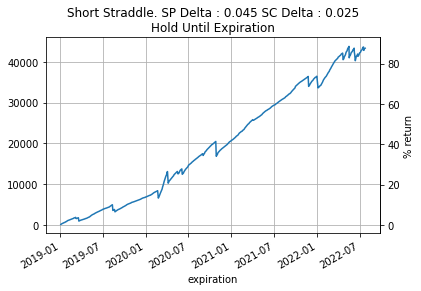

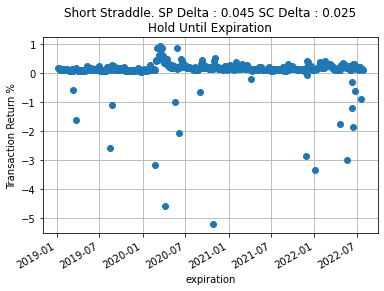

In [9]:
# strat2 = AlwaysOpenShortStraddleDynamicEntryDynamicMaxLossExitStrategy(commission,1,0.04, 0.02, df_ty, initial_portfolio_value, 3, debug = True)
# sharp = strat2.evaluate(df)

# strat1 = StaticShortStraddleMaxLossExitStrategy(commission,1,purchase_time,0.08, 0.08, df_ty, initial_portfolio_value, 2, debug = True)
# sharp = strat1.evaluate(df)
# strat = StaticShortIronCondorHoldToExpStrategy(commission,1,purchase_time,0.09,0.09, 0.01, 0.01, df_ty, initial_portfolio_value, debug = True)
strat = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,0.045,0.025,None,None, df_ty, initial_portfolio_value, debug = True)
sharp = strat.evaluate(df)


# entry_policy = ShortStraddleStaticEntryPolicy(commission, 1, purchase_time, 0.04,0.02)
# df_trades = entry_policy.populateTrades(df)
# df_trades


In [10]:
def run_backtest(strat, df):
    return strat.evaluate(df)

In [11]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.45)
#     delta_lp_trial = trial.suggest_float("delta_p_offset", 0.001, 0.5)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.45)
#     delta_lc_trial = trial.suggest_float("delta_c_offset", 0.001, 0.50)
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    
    strategy = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,delta_sp_trial,delta_sc_trial,None,None, df_ty, initial_portfolio_value)
    score = run_backtest(strategy, df)
    return score

In [12]:
study_name = "optimal-short-straddle-study_2019-2022_1DTE_1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 200)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-07-25 23:46:39,748] A new study created in RDB with name: optimal-short-straddle-study_2019-2022_1DTE_1
[I 2023-07-25 23:46:50,072] Trial 0 finished with value: 896.276 and parameters: {'delta_sp': 0.053367816383099606, 'delta_sc': 0.44121683016442953}. Best is trial 0 with value: 896.276.
[I 2023-07-25 23:46:59,965] Trial 1 finished with value: 11157.915 and parameters: {'delta_sp': 0.11179362394686725, 'delta_sc': 0.1218584055071363}. Best is trial 1 with value: 11157.915.
[I 2023-07-25 23:47:09,864] Trial 2 finished with value: 6075.381 and parameters: {'delta_sp': 0.026449750139431134, 'delta_sc': 0.17435331991924166}. Best is trial 1 with value: 11157.915.
[I 2023-07-25 23:47:19,664] Trial 3 finished with value: 4370.236 and parameters: {'delta_sp': 0.13686254891271363, 'delta_sc': 0.2746180349520716}. Best is trial 1 with value: 11157.915.
[I 2023-07-25 23:47:29,500] Trial 4 finished with value: 3112.829 and parameters: {'delta_sp': 0.31508155199586296, 'delta_sc': 0.3332

[I 2023-07-25 23:48:37,772] Trial 11 finished with value: 9040.598 and parameters: {'delta_sp': 0.17553770147750183, 'delta_sc': 0.0024071696084032868}. Best is trial 1 with value: 11157.915.
[I 2023-07-25 23:48:47,538] Trial 12 finished with value: 8934.82 and parameters: {'delta_sp': 0.24284153322239074, 'delta_sc': 0.07796414501450832}. Best is trial 1 with value: 11157.915.
[I 2023-07-25 23:48:57,174] Trial 13 finished with value: 12849.537 and parameters: {'delta_sp': 0.11655559654112527, 'delta_sc': 0.074250658245677}. Best is trial 13 with value: 12849.537.
[I 2023-07-25 23:49:06,946] Trial 14 finished with value: 6271.474 and parameters: {'delta_sp': 0.10655974314629417, 'delta_sc': 0.2116443845338149}. Best is trial 13 with value: 12849.537.
[I 2023-07-25 23:49:16,534] Trial 15 finished with value: 11319.303 and parameters: {'delta_sp': 0.10148229923522901, 'delta_sc': 0.12402958677917425}. Best is trial 13 with value: 12849.537.
[I 2023-07-25 23:49:26,258] Trial 16 finished w

[I 2023-07-25 23:54:07,349] Trial 45 finished with value: 27802.176 and parameters: {'delta_sp': 0.03102225373179089, 'delta_sc': 0.002021176171209376}. Best is trial 44 with value: 53020.232.


[I 2023-07-25 23:54:16,962] Trial 46 finished with value: 28743.25 and parameters: {'delta_sp': 0.030373908768497465, 'delta_sc': 0.003789859300267869}. Best is trial 44 with value: 53020.232.


[I 2023-07-25 23:54:26,412] Trial 47 finished with value: 4658.029 and parameters: {'delta_sp': 0.33739818139755146, 'delta_sc': 0.0020713137308291645}. Best is trial 44 with value: 53020.232.


[I 2023-07-25 23:54:35,973] Trial 48 finished with value: 5833.428 and parameters: {'delta_sp': 0.26943750162669877, 'delta_sc': 0.00231412525234783}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:54:45,516] Trial 49 finished with value: 4423.468 and parameters: {'delta_sp': 0.43281025612960067, 'delta_sc': 0.030338976251345958}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:54:55,499] Trial 50 finished with value: 13379.864 and parameters: {'delta_sp': 0.03660659327799904, 'delta_sc': 0.08725508005461398}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:55:05,099] Trial 51 finished with value: 36397.142 and parameters: {'delta_sp': 0.023825307858610673, 'delta_sc': 0.019630458566109205}. Best is trial 44 with value: 53020.232.


[I 2023-07-25 23:55:14,637] Trial 52 finished with value: 9045.554 and parameters: {'delta_sp': 0.002360475352214654, 'delta_sc': 0.023415781120981933}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:55:24,242] Trial 53 finished with value: 13204.078 and parameters: {'delta_sp': 0.09077502288513675, 'delta_sc': 0.013084033589935012}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:55:33,747] Trial 54 finished with value: 5583.962 and parameters: {'delta_sp': 0.402821548935851, 'delta_sc': 0.07592737325889025}. Best is trial 44 with value: 53020.232.


[I 2023-07-25 23:55:44,320] Trial 55 finished with value: 18268.868 and parameters: {'delta_sp': 0.03782260063571667, 'delta_sc': 0.002876334217684535}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:55:54,531] Trial 56 finished with value: 1129.722 and parameters: {'delta_sp': 0.024619789987797985, 'delta_sc': 0.310954555736237}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:56:03,963] Trial 57 finished with value: 13293.397 and parameters: {'delta_sp': 0.09079558899640405, 'delta_sc': 0.03386123886272645}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:56:16,738] Trial 58 finished with value: 151.39 and parameters: {'delta_sp': 0.018140740611708797, 'delta_sc': 0.40046933233480364}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:56:28,322] Trial 59 finished with value: 14268.842 and parameters: {'delta_sp': 0.04071972485292819, 'delta_sc': 0.06673448914209254}. Best is trial 44 with value: 53020.232.
[I 2023-07-25 23:56:38,315] Trial 60 finish

[I 2023-07-25 23:58:33,608] Trial 72 finished with value: 84269.063 and parameters: {'delta_sp': 0.0021051654144142867, 'delta_sc': 0.012423103420967868}. Best is trial 72 with value: 84269.063.


[I 2023-07-25 23:58:43,037] Trial 73 finished with value: 5942.336 and parameters: {'delta_sp': 0.0025656655212487572, 'delta_sc': 0.05161604542034222}. Best is trial 72 with value: 84269.063.
[I 2023-07-25 23:58:52,960] Trial 74 finished with value: 21083.741 and parameters: {'delta_sp': 0.01778468695052117, 'delta_sc': 0.029892573601796417}. Best is trial 72 with value: 84269.063.
[I 2023-07-25 23:59:02,345] Trial 75 finished with value: 46964.178 and parameters: {'delta_sp': 0.02748503781658205, 'delta_sc': 0.014166039662132954}. Best is trial 72 with value: 84269.063.
[I 2023-07-25 23:59:11,691] Trial 76 finished with value: 15926.305 and parameters: {'delta_sp': 0.05619028539538499, 'delta_sc': 0.012079342454432497}. Best is trial 72 with value: 84269.063.
[I 2023-07-25 23:59:21,098] Trial 77 finished with value: 20730.57 and parameters: {'delta_sp': 0.028311800009274236, 'delta_sc': 0.03916545592910951}. Best is trial 72 with value: 84269.063.
[I 2023-07-25 23:59:30,485] Trial 78

[I 2023-07-25 23:59:49,241] Trial 80 finished with value: 5539.337 and parameters: {'delta_sp': 0.00229096409031309, 'delta_sc': 0.06892414033863797}. Best is trial 72 with value: 84269.063.
[I 2023-07-25 23:59:59,315] Trial 81 finished with value: 18449.01 and parameters: {'delta_sp': 0.015754451188657294, 'delta_sc': 0.02851301297365262}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:00:08,802] Trial 82 finished with value: 26647.32 and parameters: {'delta_sp': 0.012707392775838383, 'delta_sc': 0.02128186533073905}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:00:18,359] Trial 83 finished with value: 17476.004 and parameters: {'delta_sp': 0.033653642919400664, 'delta_sc': 0.045331740803586}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:00:27,837] Trial 84 finished with value: 13800.099 and parameters: {'delta_sp': 0.07181204052505447, 'delta_sc': 0.01676749754508477}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:00:37,283] Trial 85 finis

[I 2023-07-26 00:01:05,699] Trial 88 finished with value: 7553.784 and parameters: {'delta_sp': 0.21088369484502628, 'delta_sc': 0.0032740942681668064}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:01:15,761] Trial 89 finished with value: 4247.13 and parameters: {'delta_sp': 0.2816457373332288, 'delta_sc': 0.24517289676123713}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:01:25,274] Trial 90 finished with value: 15099.241 and parameters: {'delta_sp': 0.06121601680726136, 'delta_sc': 0.022994339045970015}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:01:34,736] Trial 91 finished with value: 26142.525 and parameters: {'delta_sp': 0.016353051532112566, 'delta_sc': 0.02257893772211338}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:01:44,221] Trial 92 finished with value: 17980.823 and parameters: {'delta_sp': 0.020739232873085725, 'delta_sc': 0.039159350121894004}. Best is trial 72 with value: 84269.063.


[I 2023-07-26 00:01:53,686] Trial 93 finished with value: 22706.433 and parameters: {'delta_sp': 0.03508602717861414, 'delta_sc': 0.0020613894192660735}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:02:02,983] Trial 94 finished with value: 16752.725 and parameters: {'delta_sp': 0.01067844108033565, 'delta_sc': 0.02480380452844151}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:02:12,369] Trial 95 finished with value: 15829.294 and parameters: {'delta_sp': 0.04470555513330562, 'delta_sc': 0.050023558275829924}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:02:21,780] Trial 96 finished with value: 50515.075 and parameters: {'delta_sp': 0.025757613434947375, 'delta_sc': 0.012709641685337034}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:02:31,743] Trial 97 finished with value: 50285.254 and parameters: {'delta_sp': 0.026095277921716644, 'delta_sc': 0.01423663035850901}. Best is trial 72 with value: 84269.063.
[I 2023-07-26 00:02:41,073] Trial 

[I 2023-07-26 00:03:09,637] Trial 101 finished with value: 86143.112 and parameters: {'delta_sp': 0.0022969647622783293, 'delta_sc': 0.013339084871717423}. Best is trial 101 with value: 86143.112.
[I 2023-07-26 00:03:19,140] Trial 102 finished with value: 61784.5 and parameters: {'delta_sp': 0.023691950808054633, 'delta_sc': 0.013686783868414418}. Best is trial 101 with value: 86143.112.


[I 2023-07-26 00:03:28,649] Trial 103 finished with value: 93394.986 and parameters: {'delta_sp': 0.0030970297818635325, 'delta_sc': 0.012526364174578008}. Best is trial 103 with value: 93394.986.


[I 2023-07-26 00:03:38,058] Trial 104 finished with value: 21116.774 and parameters: {'delta_sp': 0.002171181365168382, 'delta_sc': 0.016365142243241107}. Best is trial 103 with value: 93394.986.
[I 2023-07-26 00:03:48,217] Trial 105 finished with value: 16214.712 and parameters: {'delta_sp': 0.021217309902516475, 'delta_sc': 0.04611966244286726}. Best is trial 103 with value: 93394.986.
[I 2023-07-26 00:03:57,746] Trial 106 finished with value: 1650.382 and parameters: {'delta_sp': 0.04081655620692798, 'delta_sc': 0.29536889269952826}. Best is trial 103 with value: 93394.986.
[I 2023-07-26 00:04:07,227] Trial 107 finished with value: 23096.536 and parameters: {'delta_sp': 0.022386939203280547, 'delta_sc': 0.031058342133626522}. Best is trial 103 with value: 93394.986.
[I 2023-07-26 00:04:16,612] Trial 108 finished with value: 9391.763 and parameters: {'delta_sp': 0.008603040745666542, 'delta_sc': 0.05768488422265969}. Best is trial 103 with value: 93394.986.
[I 2023-07-26 00:04:26,125

[I 2023-07-26 00:05:42,500] Trial 117 finished with value: 80746.563 and parameters: {'delta_sp': 0.002009729758592366, 'delta_sc': 0.008777004349412901}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:05:51,983] Trial 118 finished with value: 9456.008 and parameters: {'delta_sp': 0.004492350710445146, 'delta_sc': 0.030389796391331738}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:06:01,361] Trial 119 finished with value: 75319.874 and parameters: {'delta_sp': 0.0024674581129903424, 'delta_sc': 0.007031789547601079}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:06:10,714] Trial 120 finished with value: 87584.655 and parameters: {'delta_sp': 0.008850294610490774, 'delta_sc': 0.0022136308099646946}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:06:20,119] Trial 121 finished with value: 93332.324 and parameters: {'delta_sp': 0.003161667855105604, 'delta_sc': 0.008477403180154691}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:06:31,843] Trial 122 finished with value: 102934.076 and parameters: {'delta_sp': 0.01026217095521017, 'delta_sc': 0.003025912196825284}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:06:42,646] Trial 123 finished with value: 66094.33 and parameters: {'delta_sp': 0.002937702595835118, 'delta_sc': 0.0022197538844169317}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:06:53,090] Trial 124 finished with value: 8580.042 and parameters: {'delta_sp': 0.0022246205252115653, 'delta_sc': 0.022310613039063537}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:07:02,486] Trial 125 finished with value: 103555.946 and parameters: {'delta_sp': 0.010710119149021608, 'delta_sc': 0.002845799012907828}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:07:11,932] Trial 126 finished with value: 111991.16 and parameters: {'delta_sp': 0.011061382436521622, 'delta_sc': 0.005653290684733047}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:07:21,447] Trial 127 finished with value: 12696.849 and parameters: {'delta_sp': 0.011467575983659814, 'delta_sc': 0.038361350242909514}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:07:30,955] Trial 128 finished with value: 108055.685 and parameters: {'delta_sp': 0.012894554934958596, 'delta_sc': 0.0022108238036537484}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:07:40,605] Trial 129 finished with value: 19994.128 and parameters: {'delta_sp': 0.03689394572692669, 'delta_sc': 0.026860669966516988}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:07:50,142] Trial 130 finished with value: 106948.729 and parameters: {'delta_sp': 0.01267070767386039, 'delta_sc': 0.0023354943264053043}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:07:59,748] Trial 131 finished with value: 25225.884 and parameters: {'delta_sp': 0.01547227527398577, 'delta_sc': 0.022689647169375285}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:08:09,377] Trial 132 finished with value: 108660.434 and parameters: {'delta_sp': 0.01375756193139315, 'delta_sc': 0.00244080493221351}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:08:18,923] Trial 133 finished with value: 110792.85 and parameters: {'delta_sp': 0.014249306725199952, 'delta_sc': 0.002131812356728246}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:08:29,390] Trial 134 finished with value: 112724.084 and parameters: {'delta_sp': 0.014805820145406538, 'delta_sc': 0.0021562226621971506}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:08:39,060] Trial 135 finished with value: 112826.413 and parameters: {'delta_sp': 0.013540120469659186, 'delta_sc': 0.006095402945609851}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:08:48,625] Trial 136 finished with value: 111151.713 and parameters: {'delta_sp': 0.014529255491970604, 'delta_sc': 0.0023580073604678718}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:08:58,174] Trial 137 finished with value: 113229.917 and parameters: {'delta_sp': 0.015371566640546211, 'delta_sc': 0.0025898637206723694}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:09:07,805] Trial 138 finished with value: 20872.044 and parameters: {'delta_sp': 0.036523176582457816, 'delta_sc': 0.027198600197376816}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:09:17,374] Trial 139 finished with value: 114539.864 and parameters: {'delta_sp': 0.01552325121608496, 'delta_sc': 0.0024298573127909157}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:09:26,990] Trial 140 finished with value: 2684.682 and parameters: {'delta_sp': 0.016526903464849342, 'delta_sc': 0.19761294594128212}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:09:36,647] Trial 141 finished with value: 376.122 and parameters: {'delta_sp': 0.016093560149351385, 'delta_sc': 0.3509429943897739}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:09:46,303] Trial 142 finished with value: 15076.727 and parameters: {'delta_sp': 0.04365108503281387, 'delta_sc': 0.002102133314833123}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:09:55,904] Trial 143 finished with value: 113913.188 and parameters: {'delta_sp': 0.015276796101927037, 'delta_sc': 0.0020618409265741166}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:10:06,415] Trial 144 finished with value: 26060.94 and parameters: {'delta_sp': 0.034884038646629166, 'delta_sc': 0.020181664048318903}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:10:16,623] Trial 145 finished with value: 30429.81 and parameters: {'delta_sp': 0.01700941872569997, 'delta_sc': 0.02183344574833655}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:10:26,215] Trial 146 finished with value: 20888.398 and parameters: {'delta_sp': 0.036629175056425926, 'delta_sc': 0.03156845955029789}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:10:35,799] Trial 147 finished with value: 16046.393 and parameters: {'delta_sp': 0.05112959333142436, 'delta_sc': 0.04332969601381053}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:10:

[I 2023-07-26 00:11:04,820] Trial 150 finished with value: 28659.522 and parameters: {'delta_sp': 0.03189017642752271, 'delta_sc': 0.004194741116920922}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:11:14,604] Trial 151 finished with value: 105612.584 and parameters: {'delta_sp': 0.011112517067217869, 'delta_sc': 0.002972401042294781}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:11:24,300] Trial 152 finished with value: 107708.177 and parameters: {'delta_sp': 0.01835551231536724, 'delta_sc': 0.0025086853103302494}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:11:34,220] Trial 153 finished with value: 5187.443 and parameters: {'delta_sp': 0.3713885525792094, 'delta_sc': 0.017319122881325574}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:11:44,554] Trial 154 finished with value: 16917.071 and parameters: {'delta_sp': 0.016493992623308674, 'delta_sc': 0.03321056985145848}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:11:54,973] Trial 155 finished with value: 24240.87 and parameters: {'delta_sp': 0.03260533579429606, 'delta_sc': 0.0021508993327910967}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:12:06,977] Trial 156 finished with value: 62675.504 and parameters: {'delta_sp': 0.019073425509833136, 'delta_sc': 0.016116468165655345}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:12:17,122] Trial 157 finished with value: 19261.774 and parameters: {'delta_sp': 0.04275003041439929, 'delta_sc': 0.026647294067930757}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:12:27,085] Trial 158 finished with value: 82672.671 and parameters: {'delta_sp': 0.021147442379958088, 'delta_sc': 0.010023387114287461}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:12:37,246] Trial 159 finished with value: 28066.902 and parameters: {'delta_sp': 0.012583887724635348, 'delta_sc': 0.01958351900415535}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:1

[I 2023-07-26 00:12:58,711] Trial 161 finished with value: 106550.32 and parameters: {'delta_sp': 0.01253855494212716, 'delta_sc': 0.003257408449763505}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:13:09,331] Trial 162 finished with value: 115180.705 and parameters: {'delta_sp': 0.01224128778525144, 'delta_sc': 0.009814433588695165}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:13:21,481] Trial 163 finished with value: 44130.797 and parameters: {'delta_sp': 0.019455213911535638, 'delta_sc': 0.018709583908003494}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:13:32,507] Trial 164 finished with value: 22382.982 and parameters: {'delta_sp': 0.029979952099928226, 'delta_sc': 0.02778635846193414}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:13:42,395] Trial 165 finished with value: 9305.051 and parameters: {'delta_sp': 0.18882091275958035, 'delta_sc': 0.012457048537313633}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:13:52,510] Trial 166 finished with value: 107822.555 and parameters: {'delta_sp': 0.012991354347075771, 'delta_sc': 0.002602275369020883}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:14:02,405] Trial 167 finished with value: 16509.481 and parameters: {'delta_sp': 0.042112970191906525, 'delta_sc': 0.002340081393968522}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:14:12,322] Trial 168 finished with value: 18484.837 and parameters: {'delta_sp': 0.023395208299625343, 'delta_sc': 0.03702767655348556}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:14:23,338] Trial 169 finished with value: 37271.873 and parameters: {'delta_sp': 0.01294414846864933, 'delta_sc': 0.01776093258255422}. Best is trial 113 with value: 117858.023.


[I 2023-07-26 00:14:33,113] Trial 170 finished with value: 23350.512 and parameters: {'delta_sp': 0.03339255471193325, 'delta_sc': 0.0020191094816332817}. Best is trial 113 with value: 117858.023.
[I 2023-07-26 00:14:42,923] Trial 171 finished with value: 118567.34 and parameters: {'delta_sp': 0.013348351697044849, 'delta_sc': 0.011820139456575245}. Best is trial 171 with value: 118567.34.
[I 2023-07-26 00:14:52,871] Trial 172 finished with value: 70115.211 and parameters: {'delta_sp': 0.02237295523450711, 'delta_sc': 0.011770178901345211}. Best is trial 171 with value: 118567.34.
[I 2023-07-26 00:15:03,063] Trial 173 finished with value: 20673.84 and parameters: {'delta_sp': 0.013809713956165197, 'delta_sc': 0.02461832785677861}. Best is trial 171 with value: 118567.34.
[I 2023-07-26 00:15:13,119] Trial 174 finished with value: 6517.968 and parameters: {'delta_sp': 0.30596643661833134, 'delta_sc': 0.01129926640558068}. Best is trial 171 with value: 118567.34.
[I 2023-07-26 00:15:23,23

[I 2023-07-26 00:17:49,295] Trial 189 finished with value: 291.507 and parameters: {'delta_sp': 0.003575418823095004, 'delta_sc': 0.2288541539376619}. Best is trial 176 with value: 120082.734.
[I 2023-07-26 00:17:59,617] Trial 190 finished with value: 24398.528 and parameters: {'delta_sp': 0.03167741959496631, 'delta_sc': 0.025495752181780316}. Best is trial 176 with value: 120082.734.


[I 2023-07-26 00:18:09,986] Trial 191 finished with value: 112074.693 and parameters: {'delta_sp': 0.014820699755429649, 'delta_sc': 0.002404618321107709}. Best is trial 176 with value: 120082.734.
[I 2023-07-26 00:18:21,226] Trial 192 finished with value: 125653.996 and parameters: {'delta_sp': 0.016459328982846674, 'delta_sc': 0.01204862472452339}. Best is trial 192 with value: 125653.996.
[I 2023-07-26 00:18:31,482] Trial 193 finished with value: 120650.385 and parameters: {'delta_sp': 0.011287063135232887, 'delta_sc': 0.011439754118417456}. Best is trial 192 with value: 125653.996.


[I 2023-07-26 00:18:41,782] Trial 194 finished with value: 96839.422 and parameters: {'delta_sp': 0.0030378621814504975, 'delta_sc': 0.011478298093609242}. Best is trial 192 with value: 125653.996.
[I 2023-07-26 00:18:51,598] Trial 195 finished with value: 36499.349 and parameters: {'delta_sp': 0.018399570878169933, 'delta_sc': 0.01932592558166337}. Best is trial 192 with value: 125653.996.
[I 2023-07-26 00:19:01,504] Trial 196 finished with value: 37374.283 and parameters: {'delta_sp': 0.028862220770669692, 'delta_sc': 0.010449897521528053}. Best is trial 192 with value: 125653.996.
[I 2023-07-26 00:19:12,739] Trial 197 finished with value: 16561.894 and parameters: {'delta_sp': 0.010830860347604998, 'delta_sc': 0.0254098718541201}. Best is trial 192 with value: 125653.996.
[I 2023-07-26 00:19:22,616] Trial 198 finished with value: 18077.626 and parameters: {'delta_sp': 0.020158821855013477, 'delta_sc': 0.03765399228897036}. Best is trial 192 with value: 125653.996.
[I 2023-07-26 00:1

Best Score:  125653.996
Best Params: 
  delta_sc: 0.01204862472452339
  delta_sp: 0.016459328982846674
